With this project I aim to show off the advantages of Bayesian neural networks (BNNs) compared to regular neural networks, namely their ability to provide confidence intervals for their predictions. The data set used can be found here: https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset?rvi=1

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid
from jax.nn import relu
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO
from numpyro.optim import Adam
from numpyro.infer import Predictive
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

Our data set consists of 303 points. The target variable is simply a binary indicator (values being 0 and 1) of whether or not the given patient had "more chance of a heart attack", to quote the author. We should note that the average value of the target variable across the data set is 0.54 and hence we do not worry about the data set being too unbalanced.

In [3]:
# Load the dataset
df = pd.read_csv('heart.csv')
X = df.drop('output', axis=1).values
y = df['output'].values

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

I assume basic familiarity with neural networks and will hence not go into too much detail. We train a neural network on our training set to predict the probability of our target variable being equal to 1. We then demonstrate both a good overall accuracy and also a good confusion matrix. A confusion matrix, $M$, is simply a matrix where $M_{i,j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$ by the model. True predictions are then shown on the diagonal where $i=j$. Here we define a correct prediction as one for which the predicted probability is less than 0.5 from the target variable.

In [4]:
# Neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)  # Output layer: 2 classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.softmax(x, dim=1)  # Softmax to convert to probability
        return x

# Instantiate the model
model = Net()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=10**(-5))

# Training the model
epochs = 1000
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    if epoch % 50 == 49:
        print(f'Epoch {epoch+1}/{epochs} Loss: {loss.item()}')
        
# Evaluate the model and calculate probabilities
model.eval()
y_prob = []  # Store probabilities for the positive class
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # We are interested in the probability of the '1' class
        prob = outputs[:, 1]  # This is the probability of class '1'
        y_prob.extend(prob.tolist())
        y_true.extend(labels.tolist())

# Convert probabilities to binary predictions using 0.5 as a threshold
y_pred = [1 if p > 0.5 else 0 for p in y_prob]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Epoch 50/1000 Loss: 0.6951649188995361
Epoch 100/1000 Loss: 0.6782267689704895
Epoch 150/1000 Loss: 0.6655423045158386
Epoch 200/1000 Loss: 0.6461778283119202
Epoch 250/1000 Loss: 0.651679515838623
Epoch 300/1000 Loss: 0.627240777015686
Epoch 350/1000 Loss: 0.6142985820770264
Epoch 400/1000 Loss: 0.613761305809021
Epoch 450/1000 Loss: 0.595384955406189
Epoch 500/1000 Loss: 0.601360023021698
Epoch 550/1000 Loss: 0.5816051363945007
Epoch 600/1000 Loss: 0.5265386700630188
Epoch 650/1000 Loss: 0.5374299883842468
Epoch 700/1000 Loss: 0.5700026154518127
Epoch 750/1000 Loss: 0.552132785320282
Epoch 800/1000 Loss: 0.5593776106834412
Epoch 850/1000 Loss: 0.5258632898330688
Epoch 900/1000 Loss: 0.4481503963470459
Epoch 950/1000 Loss: 0.43495795130729675
Epoch 1000/1000 Loss: 0.4846125841140747
Confusion Matrix:
[[25  4]
 [ 3 29]]
Accuracy: 88.52%


We can now make the BNN. As a short introduction to BNNs I will say that the main difference between a BNN and a normal neural network is that where the normal neural network has fixed weights a BNN has a probability distribution of potential weights. At inference the BNN then samples weights from the probability distribution and makes a prediction in the same way a normal neural network would. Since this prediction is reliant on the specific sample, and hence random in nature, it is common to make several predictions for the same data point and then take the average of these. You then have an approximate distribution of predictions. The advantage of this over a deterministic prediction is that you can tell how certain the BNN is of its predictions. For a well-trained BNN it will have low uncertainty in the prediction of a data point if it has been trained on data similar to the data point in question, and conversely, have high uncertainty if it has not. One of the great advantages of this is that we have an indication that the model might be wrong if it has high uncertainty because it indicates the model has not seen similar data before. The downside of BNNs is that they are more mathematically convoluted and computationally expensive to train. Let us now create the model and see its performance relative to the previous model:

In [5]:
# Define the Bayesian neural network model
n = 1
# Define the Bayesian neural network model with probability output
def bnn_model(X, y=None, hidden_size=64*n):
    # Input size is determined by the number of features in the dataset
    input_size = X.shape[1]
    # Output size is set to 1 for binary classification (probability of class 1)
    output_size = 1
    #variance = 0.5
    variance = 0.5

    # Define the priors for the weights and biases of each layer of the network
    # We use normal priors for weights and biases
    weights1 = numpyro.sample('weights1', dist.Normal(jnp.zeros((input_size, hidden_size)), 
                                                      variance * jnp.ones((input_size, hidden_size))))
    biases1 = numpyro.sample('biases1', dist.Normal(jnp.zeros(hidden_size), variance * jnp.ones(hidden_size)))
    weights2 = numpyro.sample('weights2', dist.Normal(jnp.zeros((hidden_size, output_size)), 
                                                      variance * jnp.ones((hidden_size, output_size))))
    biases2 = numpyro.sample('biases2', dist.Normal(jnp.zeros(output_size), variance * jnp.ones(output_size)))

    # Define the deterministic forward pass through the network
    def forward(x):
        x = relu(jnp.dot(x, weights1) + biases1)
        logits = jnp.dot(x, weights2) + biases2
        # Use a sigmoid function to convert logits to probabilities
        return jax.nn.sigmoid(logits)

    # Get the probability of class 1
    probs = forward(X).squeeze(-1)  # Ensure it's a 1D array suitable for Bernoulli

    # If y is provided, it means we are training the model, so we observe the data
    if y is not None:
        numpyro.sample('y', dist.Bernoulli(probs), obs=y)
    else:
        # When y is not provided, we are making predictions, so we return the probabilities
        #return probs
        return numpyro.deterministic("y", probs)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to JAX numpy arrays
X_train_jax = jnp.array(X_train)
y_train_jax = jnp.array(y_train)
X_test_jax = jnp.array(X_test)
y_test_jax = jnp.array(y_test)

# Set up the MCMC with NUTS sampler
nuts_kernel = NUTS(bnn_model,step_size = 10**(-5))
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000)

# Run the MCMC to sample from the posterior
mcmc.run(random.PRNGKey(0), X_train_jax, y_train_jax)

# Get the posterior samples
posterior_samples = mcmc.get_samples()

# Define a predictive model using the samples we got from MCMC
predictive = Predictive(bnn_model, posterior_samples)

# Get the predicted probabilities from the posterior predictive distribution
y_hat = predictive(random.PRNGKey(1), X_test_jax)['y']

# Since the output is Bernoulli probabilities, we take the mean over the samples to get the final prediction
y_prob = jnp.mean(y_hat, axis=0)

# Convert probabilities to binary predictions using 0.5 as a threshold
y_pred = (y_prob > 0.5).astype(int)

# Calculate the confusion matrix and accuracy
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Accuracy: {accuracy * 100:.2f}%')

sample: 100%|█| 2500/2500 [00:19<00:00, 129.86it/s, 127 steps of size 4.92e-02. 


Confusion Matrix:
[[25  4]
 [ 4 28]]
Accuracy: 86.89%


We get the exact same confusion matrix in both models. We can now proceed to make a plot of the BNN's predictions of the test set. We will include confidence interval and colour the points according to whether or not the BNN's prediction is true.

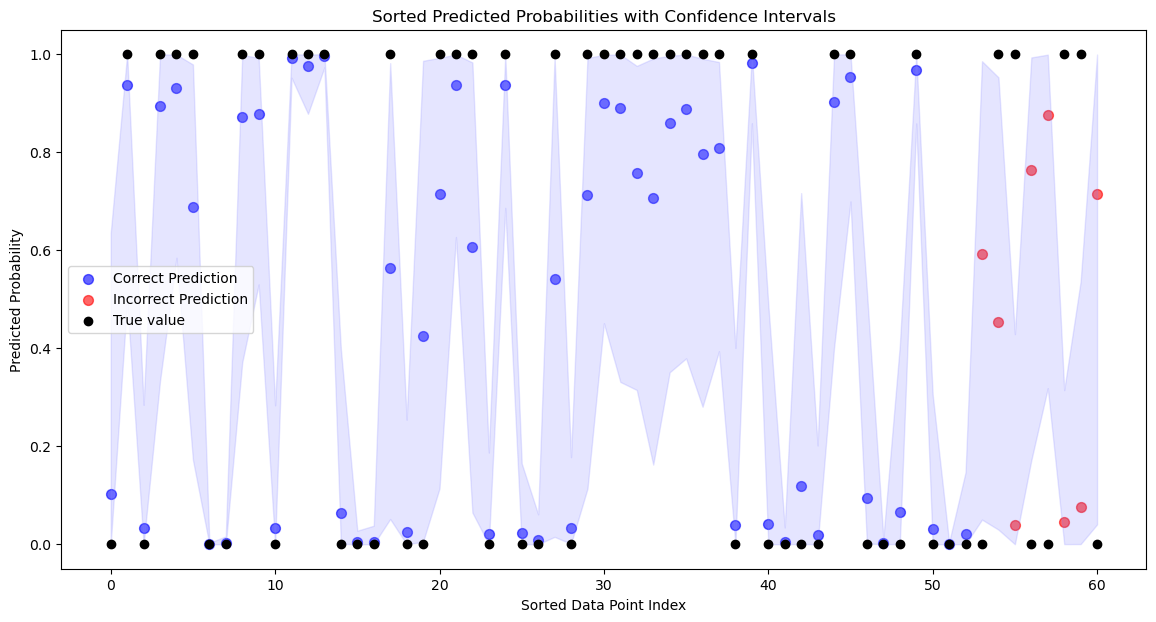

In [6]:
# Calculate mean predicted probabilities and confidence intervals
mean_probs = jnp.mean(y_hat, axis=0)
ci_lower = jnp.percentile(y_hat, 2.5, axis=0)
ci_upper = jnp.percentile(y_hat, 97.5, axis=0)

# Determine the predicted classes based on the mean probabilities
predicted_classes = (mean_probs > 0.5).astype(int)

# Find out where the model's predictions are correct or incorrect
correct_indices = predicted_classes == y_test
incorrect_indices = ~correct_indices

# Sort mean_probs based on correct and incorrect predictions
sorted_indices = jnp.concatenate([jnp.where(correct_indices)[0], jnp.where(incorrect_indices)[0]])
sorted_mean_probs = mean_probs[sorted_indices]
sorted_ci_lower = ci_lower[sorted_indices]
sorted_ci_upper = ci_upper[sorted_indices]

# Determine the boundary index between correct and incorrect predictions
boundary_index = correct_indices.sum()

# Generate the plot
plt.figure(figsize=(14, 7))

# Plot sorted correct predictions in blue
plt.scatter(jnp.arange(boundary_index), sorted_mean_probs[:boundary_index], color='blue', label='Correct Prediction', alpha=0.6, s=50)

# Plot sorted incorrect predictions in red
plt.scatter(jnp.arange(boundary_index, len(mean_probs)), sorted_mean_probs[boundary_index:], color='red', label='Incorrect Prediction', alpha=0.6, s=50)

# Plot confidence intervals for sorted predictions
plt.fill_between(jnp.arange(len(mean_probs)), sorted_ci_lower, sorted_ci_upper, color='#8080FF', alpha=0.2)

#plt.scatter(jnp.arange(len(mean_probs)), sorted_ci_lower, color='green', alpha=0.6, s=10)
#plt.scatter(jnp.arange(len(mean_probs)), sorted_ci_upper, color='green', alpha=0.6, s=10)

# Plot true values
plt.scatter(range(len(y_test)),y_test[sorted_indices],color = "black", label = "True value")

# Add labels and legend
plt.xlabel('Sorted Data Point Index')
plt.ylabel('Predicted Probability')
plt.title('Sorted Predicted Probabilities with Confidence Intervals')
plt.legend()

# Show the plot
plt.show()

Finally, we can show that it is indeed the case that the BNN on average has wider confidence intervals for its incorrect predictions:

In [7]:
print("Average length of confidence intervals for correct predictions: ",np.mean(ci_upper[correct_indices]-ci_lower[correct_indices]))
print("Average length of confidence intervals for incorrect predictions: ",np.mean(ci_upper[incorrect_indices]-ci_lower[incorrect_indices]))
print("Minimum length of confidence intervals for correct predictions: ",np.min(ci_upper[correct_indices]-ci_lower[correct_indices]))
print("Minimum length of confidence intervals for incorrect predictions: ",np.min(ci_upper[incorrect_indices]-ci_lower[incorrect_indices]))

Average length of confidence intervals for correct predictions:  0.41759008
Average length of confidence intervals for incorrect predictions:  0.69986933
Minimum length of confidence intervals for correct predictions:  0.002987766
Minimum length of confidence intervals for incorrect predictions:  0.3142535
